In [13]:
# %pip install transformers
# %pip install torch
# %pip install tf-keras
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn

In [14]:
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

Fichier chargé : ..\..\etl\data\reviews_20251212_172357.jsonl


,id_review,is_verified,date_review,id_user,user_name,user_review,user_review_length,user_rating,date_response,enterprise_response,enterprise_name,enterprise_url,enterprise_rating,enterprise_review_number,enterprise_percentage_one_star,enterprise_percentage_two_star,enterprise_percentage_three_star,enterprise_percentage_four_star,enterprise_percentage_five_star
0,693c336f754f02f7d8218bd6,False,2025-12-12,58a04f6c0000ff000a76894d,sophie,J ai commandé une suspension nettfite sur le s...,270,1.0,None,indisponible,Showroomprive,www.showroomprive.com,3.9,257151,13,9,17,24,39
1,693c28b3b6555ff4239befef,False,2025-12-12,555c47f30000ff0001c03f07,le metayer thierry,matelas Emma hybride 2 reconditionné en 160x20...,450,1.0,None,indisponible,Showroomprive,www.showroomprive.com,3.9,257151,13,9,17,24,39
2,693c268ee2a51b6c25f50731,False,2025-12-12,63a144facfddc800124b9782,Elodie Charondiere,À chaque fois que je commande ou ils annulent ...,263,1.0,None,indisponible,Showroomprive,www.showroomprive.com,3.9,257151,13,9,17,24,39
3,693c224e2429e922cd43e734,True,2025-12-12,693c224d00ecba85ff84fde0,Chahrazed,J'ai commandé des bottes avec lacets je me ret...,72,2.0,None,indisponible,Showroomprive,www.showroomprive.com,3.9,257151,13,9,17,24,39
4,693c21c04e27508152ee7659,True,2025-12-12,660061b5d7209b0012e01356,Malica,"Très bon vêtements et très bon prix, toujours ...",73,5.0,None,indisponible,Showroomprive,www.showroomprive.com,3.9,257151,13,9,17,24,39


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Fichier exporté : sentiment_analysis_reviews.csv


,user_review,user_rating,sentiment_attendu,ac0hik/Sentiment_Analysis_French,cmarkea/distilcamembert-base-sentiment,tabularisai/multilingual-sentiment-analysis
0,J ai commandé une suspension nettfite sur le s...,1.0,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
1,matelas Emma hybride 2 reconditionné en 160x20...,1.0,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,À chaque fois que je commande ou ils annulent ...,1.0,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
3,J'ai commandé des bottes avec lacets je me ret...,2.0,NEGATIVE,NEUTRAL,NEGATIVE,NEUTRAL
4,"Très bon vêtements et très bon prix, toujours ...",5.0,POSITIVE,POSITIVE,POSITIVE,POSITIVE



ac0hik/Sentiment_Analysis_French
Accuracy  : 0.830
Precision : 0.849
Recall    : 0.830
F1-score  : 0.832

cmarkea/distilcamembert-base-sentiment
Accuracy  : 0.890
Precision : 0.914
Recall    : 0.890
F1-score  : 0.897

tabularisai/multilingual-sentiment-analysis
Accuracy  : 0.710
Precision : 0.833
Recall    : 0.710
F1-score  : 0.753


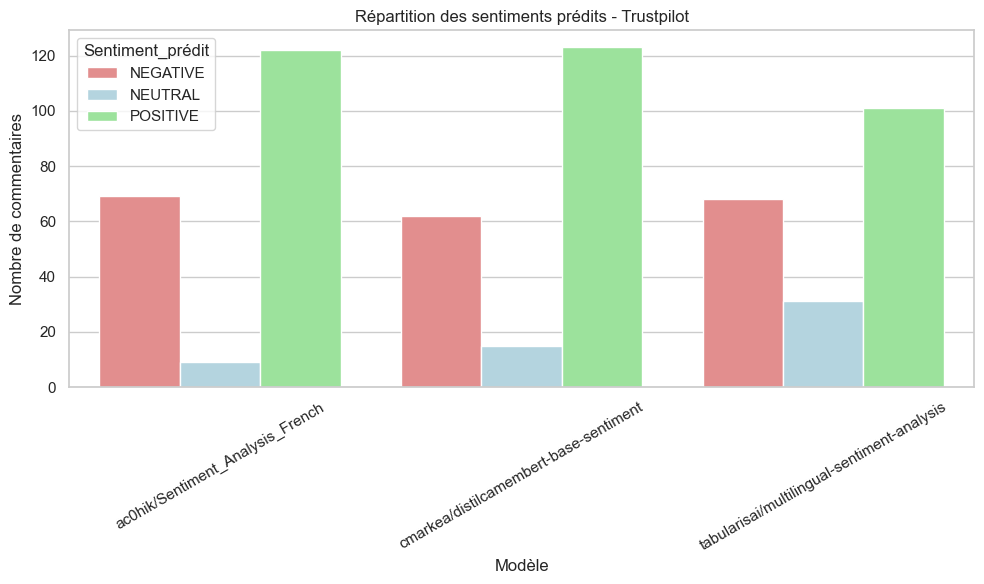

In [ ]:
# CHARGEMENT DU FICHIER JSONL
data_dir = Path("../../etl/data")
jsonl_files = list(data_dir.glob("reviews_*.jsonl"))

if not jsonl_files:
    raise FileNotFoundError(f"Aucun fichier reviews_*.jsonl trouvé dans {data_dir.resolve()}")

jsonl_path = jsonl_files[0]
print(f"Fichier chargé : {jsonl_path}")

data = []
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# On garde uniquement les lignes avec commentaire
df = df[df["user_review"].notna()].reset_index(drop=True)
display(df.head())

# PRÉPARATION DES DONNÉES
texts = df["user_review"].tolist()

def rating_to_sentiment(rating):
    if rating <= 2:
        return "NEGATIVE"
    elif rating == 3:
        return "NEUTRAL"
    else:
        return "POSITIVE"

df["sentiment_attendu"] = df["user_rating"].apply(rating_to_sentiment)

# CHARGEMENT DES MODÈLES HUGGING FACE
model_names = [
    "ac0hik/Sentiment_Analysis_French",
    "cmarkea/distilcamembert-base-sentiment",
    "tabularisai/multilingual-sentiment-analysis"
]

models = {
    name: pipeline(
        task="sentiment-analysis",
        model=name,
        tokenizer=name,
        truncation=True
    )
    for name in model_names
}

# NORMALISATION DES LABELS
def convert_stars_to_sentiment(label):
    if label in ["1 STAR", "2 STARS"]:
        return "NEGATIVE"
    elif label == "3 STARS":
        return "NEUTRAL"
    elif label in ["4 STARS", "5 STARS"]:
        return "POSITIVE"
    else:
        raise ValueError(f"Label inattendu (stars) : {label}")

def multilingual_label_to_sentiment(label):
    """
    Gestion du modèle tabularisai/multilingual-sentiment-analysis
    Normalise tout label possible : chiffres 0-4, français ou anglais.
    """
    label_lower = str(label).strip().lower()
    
    if label_lower in ["0", "1", "très négatif", "négatif", "very negative", "negative"]:
        return "NEGATIVE"
    elif label_lower in ["2", "neutre", "neutral"]:
        return "NEUTRAL"
    elif label_lower in ["3", "4", "positif", "très positif", "positive", "very positive"]:
        return "POSITIVE"
    else:
        raise ValueError(f"Label inattendu (multilingual) : {label}")

def normalize_label(model_name, label):
    if model_name == "tabularisai/multilingual-sentiment-analysis":
        return multilingual_label_to_sentiment(label)

    label = str(label).upper()

    if model_name == "cmarkea/distilcamembert-base-sentiment":
        return convert_stars_to_sentiment(label)

    if label in ["LABEL_0", "NEGATIVE"]:
        return "NEGATIVE"
    elif label in ["LABEL_1", "POSITIVE"]:
        return "POSITIVE"
    elif label in ["LABEL_2", "NEUTRAL"]:
        return "NEUTRAL"

    raise ValueError(f"Label inattendu : {label} ({model_name})")

# PRÉDICTIONS
for model_name, model in models.items():
    predictions = []
    for text in texts:
        result = model(text, truncation=True, max_length=512)[0]
        label = normalize_label(model_name, result["label"])
        predictions.append(label)
    df[model_name] = predictions

# EXPORT CSV
output_path = "sentiment_analysis_reviews.csv"
df[
    [
        "user_review",
        "user_rating",
        "sentiment_attendu",
        "ac0hik/Sentiment_Analysis_French",
        "cmarkea/distilcamembert-base-sentiment",
        "tabularisai/multilingual-sentiment-analysis"
    ]
].to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"Fichier exporté : {output_path}")

# APERÇU DES RÉSULTATS
display(
    df[["user_review", "user_rating", "sentiment_attendu"] + model_names].head()
)

# ÉVALUATION DES MODÈLES
metrics = {}
for model_name in model_names:
    y_true = df["sentiment_attendu"]
    y_pred = df[model_name]
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=1
    )
    metrics[model_name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

for model, m in metrics.items():
    print(f"\n{model}")
    print(f"Accuracy  : {m['accuracy']:.3f}")
    print(f"Precision : {m['precision']:.3f}")
    print(f"Recall    : {m['recall']:.3f}")
    print(f"F1-score  : {m['f1']:.3f}")

# VISUALISATION
sns.set_theme(style="whitegrid")

df_plot = df.melt(
    id_vars="sentiment_attendu",
    value_vars=model_names,
    var_name="Modèle",
    value_name="Sentiment_prédit"
)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_plot,
    x="Modèle",
    hue="Sentiment_prédit",
    palette={
        "POSITIVE": "lightgreen",
        "NEGATIVE": "lightcoral",
        "NEUTRAL": "lightblue"
    }
)
plt.title("Répartition des sentiments prédits")
plt.ylabel("Nombre de commentaires")
plt.xlabel("Modèle")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
